# final_submission
- 温度条件ごとに、current_cumsum を利用した線形モデルを学習する
- 温度条件ごとに、GroupKFoldをする

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
ROOT_DIR = Path().resolve()

with open(ROOT_DIR.joinpath("configs", "train_temp2fn.json"), "r") as f:
    train_temp2fn =  json.load(f)
with open(ROOT_DIR.joinpath("configs", "test_temp2fn.json"), "r") as f:
    test_temp2fn =  json.load(f)

TEMPS = sorted(train_temp2fn.keys())
TEMPS

['-10', '-20', '0', '10', '25']

In [3]:
sub = pd.read_csv(ROOT_DIR.joinpath("input", "sample_submission.csv"))
sub.index = sub["ID"]
sub["SOC"] = 100.0
sub.head()

,ID,SOC
ID,,
0,0,100.0
1,1,100.0
2,2,100.0
3,3,100.0
4,4,100.0


In [4]:
scores = {
    "coefficient": {
        "train": {}, "valid": {}
    }, 
    "rmse": {
         "train": {}, "valid": {}, 
    }
}

## 1. 温度条件ごとに、GroupKFoldで学習

In [5]:
# 温度条件ごとにモデル構築
for _temp in TEMPS:
    train_files = train_temp2fn[_temp]
    train_data = pd.DataFrame()
    print(f"====== Start training models where temperature: {_temp} ======")
    
    for fold_id, train_file in enumerate(train_files):
        _df = pd.read_pickle(train_file)[["Current", "SOC"]]
        
        # 電流の計測値の累積話 (current_cumsum) を計算
        _df["Current_cumsum"] = _df["Current"].cumsum()
        _df["fold_id"] = fold_id
        _df.drop("Current", axis=1, inplace=True)
        train_data = pd.concat([train_data, _df])
    train_data = train_data.reset_index(drop=True)
    
    valid_preds = np.zeros((train_data.shape[0]))
    models = []
    
    # GroupKFoldで交差検証
    for fold_id in range(len(train_files)):
        tr_data = train_data.query(f"fold_id != {fold_id}")
        val_data = train_data.query(f"fold_id == {fold_id}")
        
        train_idxs = tr_data.index
        valid_idxs = val_data.index
        
        X_tr = tr_data["Current_cumsum"].values.reshape(-1, 1)
        y_tr = tr_data["SOC"]
        
        X_val = val_data["Current_cumsum"].values.reshape(-1, 1)
        y_val = val_data["SOC"]
        
        print(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)
        
        # 線形回帰モデルを学習
        model = LinearRegression(
            fit_intercept=True,
            normalize=False,
            n_jobs=-1,
            positive=False
        )
        model.fit(X_tr, y_tr)
        
        # モデルの評価
        for X, y, mode in zip([X_tr, X_val], [y_tr, y_val], ["train", "valid"]):
            pred = model.predict(X)
            coef = model.score(X, y)
            rmse = mean_squared_error(y, pred, squared=False)
            scores["coefficient"][mode][_temp] = coef
            scores["rmse"][mode][_temp] = rmse
            print(f"fold: {fold_id} - {mode}_coef: {coef:.04f} -- {mode}_rmse={rmse:.04f}")
            
            if model == "valid":
                valid_preds[valid_idxs] = pred
        models.append(model)
    
    # テストデータで予測
    test_files = test_temp2fn[_temp]
    for test_file in test_files:        
        test_df = pd.read_pickle(test_file)
        
        # 電流の計測値の累積話 (current_cumsum) を計算
        test_df["Current_cumsum"] = test_df["Current"].cumsum()
        
        # GroupKFoldの各モデルで予測
        test_preds = np.zeros((len(models), test_df.shape[0]))
        for fold_id, model in enumerate(models):
            test_pred = model.predict(test_df["Current_cumsum"].values.reshape(-1, 1))
            test_preds[fold_id] = test_pred
        
        # Averaging
        test_preds = np.mean(test_preds, axis=0)
        sub.loc[test_df.ID, "SOC"] = test_preds

====== Start training models where temperature: -10 ======
(77600, 1) (57234, 1) (77600,) (57234,)
fold: 0 - train_coef: 1.0000 -- train_rmse=0.0128
fold: 0 - valid_coef: 1.0000 -- valid_rmse=0.0108
(106756, 1) (28078, 1) (106756,) (28078,)
fold: 1 - train_coef: 1.0000 -- train_rmse=0.0116
fold: 1 - valid_coef: 1.0000 -- valid_rmse=0.0105
(85312, 1) (49522, 1) (85312,) (49522,)
fold: 2 - train_coef: 1.0000 -- train_rmse=0.0080
fold: 2 - valid_coef: 1.0000 -- valid_rmse=0.0165
====== Start training models where temperature: -20 ======
(89954, 1) (23557, 1) (89954,) (23557,)
fold: 0 - train_coef: 1.0000 -- train_rmse=0.0101
fold: 0 - valid_coef: 1.0000 -- valid_rmse=0.0162
(71269, 1) (42242, 1) (71269,) (42242,)
fold: 1 - train_coef: 1.0000 -- train_rmse=0.0118
fold: 1 - valid_coef: 1.0000 -- valid_rmse=0.0111
(65799, 1) (47712, 1) (65799,) (47712,)
fold: 2 - train_coef: 1.0000 -- train_rmse=0.0102
fold: 2 - valid_coef: 1.0000 -- valid_rmse=0.0142
====== Start training models where tempe

In [6]:
for mode in ["train", "valid"]:
    print(f"{mode}_coefficient: {np.mean(list(scores['coefficient'][mode].values()))}", end=" - ")
    print(f"{mode}_rmse: {np.mean(list(scores['rmse'][mode].values()))}")

train_coefficient: 0.9999994895904718 - train_rmse: 0.015150832699303122
valid_coefficient: 0.9999978102289141 - valid_rmse: 0.03275735631193335


<AxesSubplot:xlabel='ID'>

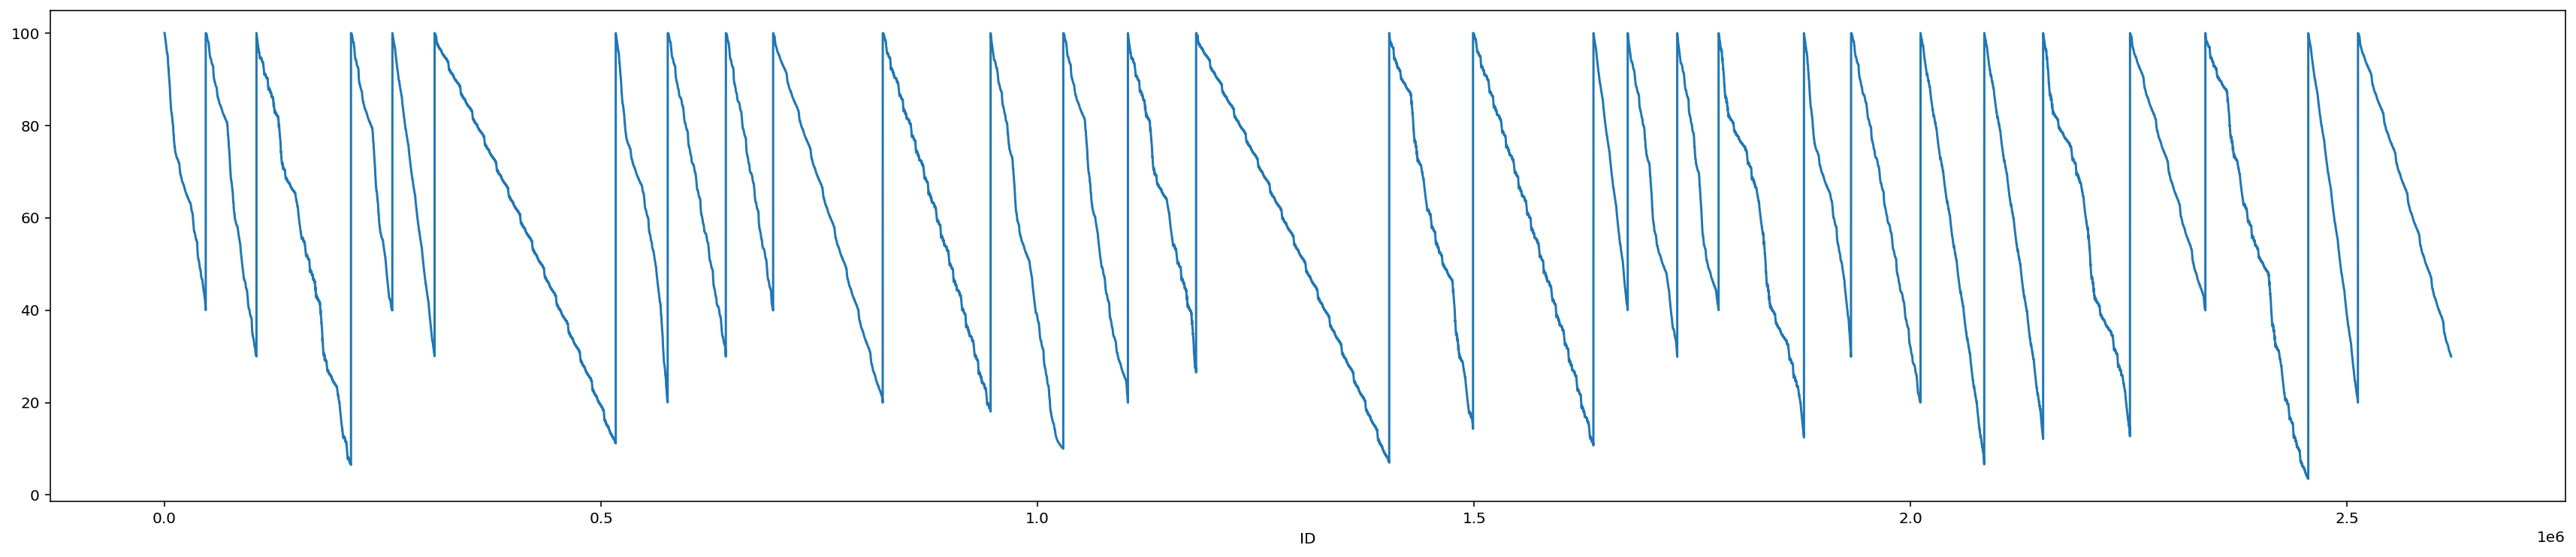

In [7]:
sub["SOC"].plot(figsize=(30, 6))

## 2. 後処理

In [8]:
sub.reset_index(drop=True, inplace=True)
sub.loc[np.where(sub.SOC > 100)[0], "SOC"] = 100
sub.loc[np.where(sub.SOC < 0)[0], "SOC"] = 0

In [9]:
sub.shape

(2618963, 2)

In [10]:
sub.head()

,ID,SOC
0,0,100.000000
1,1,100.000000
2,2,100.000000
3,3,100.000000
4,4,99.998569


In [11]:
sub.to_csv(ROOT_DIR.joinpath("submission.csv"), index=False, header=True)